#What is Melanoma?

##Watch this video for medical facts about Melanoma

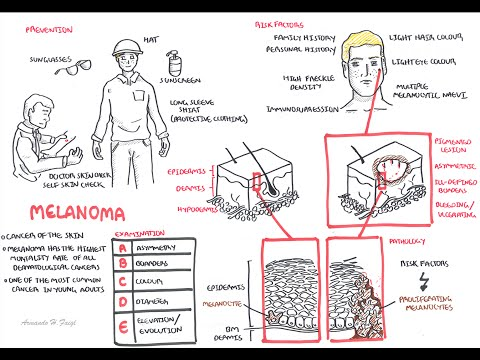

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('mkYBxfKDyv0')

#Data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

<div align='center'><font size="6" color="#F39C12">SIIM-ISIC Melanoma Classification -EDA </font></div>
<hr>

![](https://impactmelanoma.org/wp-content/uploads/2018/11/Standard-Infographic_0.jpg)
https://impactmelanoma.org/wp-content/uploads/2018/11/Standard-Infographic_0.jpg

Melanoma is a skin cancer that arises from a skin cell called a melanocyte, which makes a the pigment (melanin) that gives your skin its color.1﻿ Melanoma can appear in different ways, most commonly as a new spot on the skin or as an already existing mole that changes in color, size, or shape. While considered the most dangerous type of skin cancer because of its ability to rapidly spread throughout the body, melanoma is generally very treatable if found early.2
https://www.verywellhealth.com/what-is-melanoma-514215


## Objective

The objective of this project is to identify melanoma in images of skin lesions. In particular, we need to use images within the same patient and determine which are likely to represent a melanoma. In other words, we need to create a model which should predict the probability whether the lesion in the image is malignantor benign.Value 0 denotes benign, and 1 indicates malignant

## Dataset
The dataset consists of images in :
* JPEG format in JPEG directory

Additionally, there is a metadata comprising of train, test and submission file in CSV format.

## Understanding the Evaluation Metric

For this particluar problem, our submissions will be evaluated using **area under the ROC curve**. An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

![](https://imgur.com/yNeAG4M.png)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

![](https://imgur.com/N3UOcBF.png)

source: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


# 1. Importing the necessary libraries

Incase you fork the notebook, make sure to keep the Internet in `ON` mode.

In [3]:

from os import listdir
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import seaborn as sns
sns.set(style="whitegrid")


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 2. Reading the Image datasets

In [4]:
# Defining data path
IMAGE_PATH = "/content/drive/My Drive/competitions/kaggle/melanoma/data(256x256)/train/train/"

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')


#Training data
print('Training data shape: ', train_df.shape)
train_df.head(5)

Training data shape:  (33126, 8)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
train_df.groupby(['benign_malignant']).count()['sex'].to_frame()

,sex
benign_malignant,
benign,32477
malignant,584


# 3. Data Exploration

## Missing Values

In [6]:
# Null values and Data types
print('Train Set')
print(train_df.info())
print('-------------')
print('Test Set')
print(test_df.info())

Train Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB
None
-------------
Test Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------             

There are some missing values in some of the columns. We shall deal with them later.

## Total Number of images

In [7]:
# Total number of images in the dataset(train+test)
print("Total images in Train set: ",train_df['image_name'].count())
print("Total images in Test set: ",test_df['image_name'].count())

Total images in Train set:  33126
Total images in Test set:  10982


## Unique IDs 

In [8]:
print(f"The total patient ids are {train_df['patient_id'].count()}, from those the unique ids are {train_df['patient_id'].value_counts().shape[0]} ")

The total patient ids are 33126, from those the unique ids are 2056 


The number of unique patients is less than the total number of patients. This means that, patients have multiple records.

In [9]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


## Exploring the Target column

In [10]:
train_df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [11]:
train_df['target'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of the Target column in the training set')

## Gender wise distribution


In [12]:
train_df['sex'].value_counts(normalize=True)

male      0.516621
female    0.483379
Name: sex, dtype: float64

In [13]:
train_df['sex'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='green',
                                                      theme='pearl',
                                                      bargap=0.8,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of the Sex column in the training set')

## Gender vs Target

In [14]:
z=train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


Text(0.5, 33.120000000000005, 'benign:0 vs malignant:1')

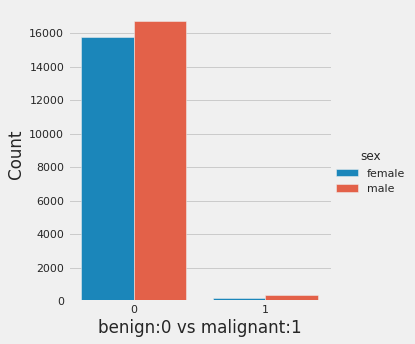

In [15]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')
plt.ylabel('Count')
plt.xlabel('benign:0 vs malignant:1')

## Location of imaged site

In [16]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values()

oral/genital       0.003804
palms/soles        0.011503
head/neck          0.056904
upper extremity    0.152857
lower extremity    0.258198
torso              0.516734
Name: anatom_site_general_challenge, dtype: float64

In [17]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values().iplot(kind='barh',
                                                      xTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='#FB8072',
                                                      theme='pearl',
                                                      bargap=0.2,
                                                      gridcolor='white',
                                                      title='Distribution of the imaged site in the training set')

## Location of imaged site w.r.t gender

Text(48.30606002604168, 0.5, 'count of melanoma cases')

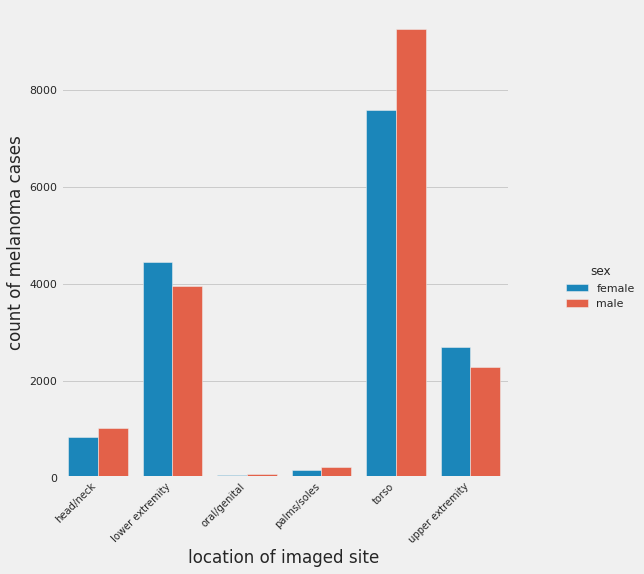

In [18]:

z1=train_df.groupby(['sex','anatom_site_general_challenge'])['benign_malignant'].count().to_frame().reset_index()
z1.style.background_gradient(cmap='Reds')
sns.catplot(x='anatom_site_general_challenge',y='benign_malignant', hue='sex',data=z1,kind='bar')
plt.gcf().set_size_inches(10,8)
plt.xlabel('location of imaged site')
plt.xticks(rotation=45,fontsize='10', horizontalalignment='right')
plt.ylabel('count of melanoma cases')


## Age Distribution of patients

In [19]:
train_df['age_approx'].iplot(kind='hist',bins=30,color='orange',xTitle='Age distribution',yTitle='Count')

## Visualising Age KDEs
Summarizing the data with Density plots to see where the mass of the data is located. [A kernel density estimate plot](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

### Distribution of Ages w.r.t Target

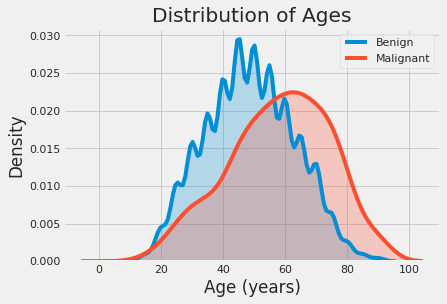

In [20]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(train_df.loc[train_df['target'] == 0, 'age_approx'], label = 'Benign',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['target'] == 1, 'age_approx'], label = 'Malignant',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


### Distribution of Ages w.r.t gender

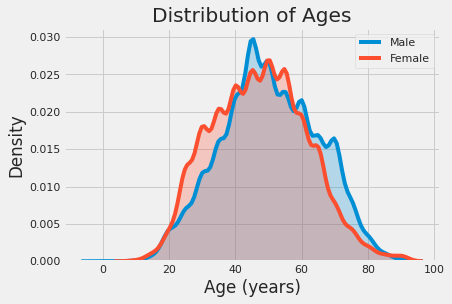

In [21]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(train_df.loc[train_df['sex'] == 'male', 'age_approx'], label = 'Male',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['sex'] == 'female', 'age_approx'], label = 'Female',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


## Distribution of Diagnosis

In [22]:
train_df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [23]:
train_df['diagnosis'].value_counts(normalize=True).sort_values().iplot(kind='barh',
                                                      xTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.2,
                                                      gridcolor='white',
                                                      title='Distribution in the training set')

## Patient Overlap 
We need to check that the the same patient lesion images shouldn't appear in both training and test set.

In [24]:
# Extract patient id's for the training set
ids_train = train_df.patient_id.values
# Extract patient id's for the validation set
ids_test = test_df.patient_id.values

# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(f'There are {len(ids_test_set)} unique Patient IDs in the training set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and test sets')
print('')
print(f'These patients are in both the training and test datasets:')
print(f'{patient_overlap}')

There are 2056 unique Patient IDs in the training set
There are 690 unique Patient IDs in the training set
There are 0 Patient IDs in both the training and test sets

These patients are in both the training and test datasets:
[]


# 4. Visualising Images : JPEG

## Visualizing a random selection of images

Display Random Images


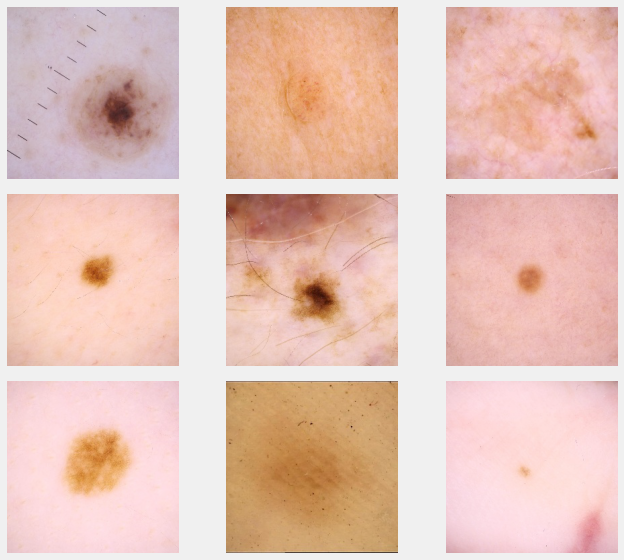

In [25]:
import os
images = train_df['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

We do see that the JPEG format images vary in sizes

## Visualizing Images with benign lesions

In [26]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

Display benign Images


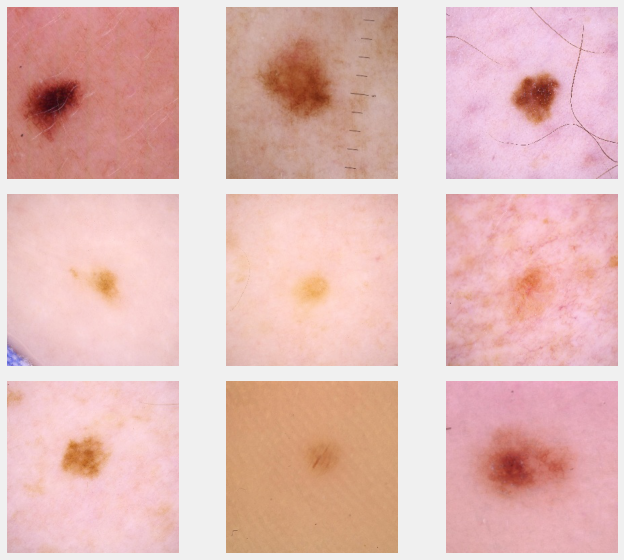

In [27]:
images = benign['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH

print('Display benign Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

## Visualizing Images with Malignant lesions

Display malignant Images


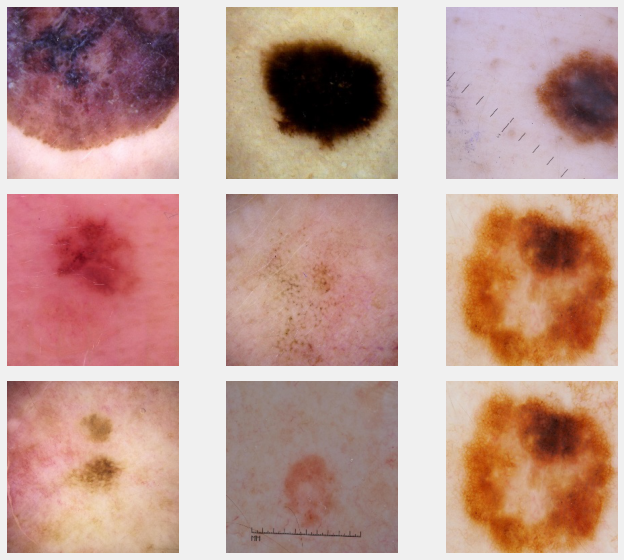

In [28]:
images = malignant['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH

print('Display malignant Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

## Histograms

Histograms are a graphical representation showing how frequently various color values occur in the image i.e frequency of pixels intensity values. In a RGB color space, pixel values range from 0 to 255 where 0 stands for black and 255 stands for white. Analysis of a histogram can help us understand thee brightness, contrast and intensity distribution of an image. Now let's look at the histogram of a random selected sample from each category.

### Benign category

Image dimensions:  (256, 256)
Maximum pixel value : 255.0 ; Minimum pixel value:19.0
Mean value of the pixels : 178.6 ; Standard deviation : 38.7


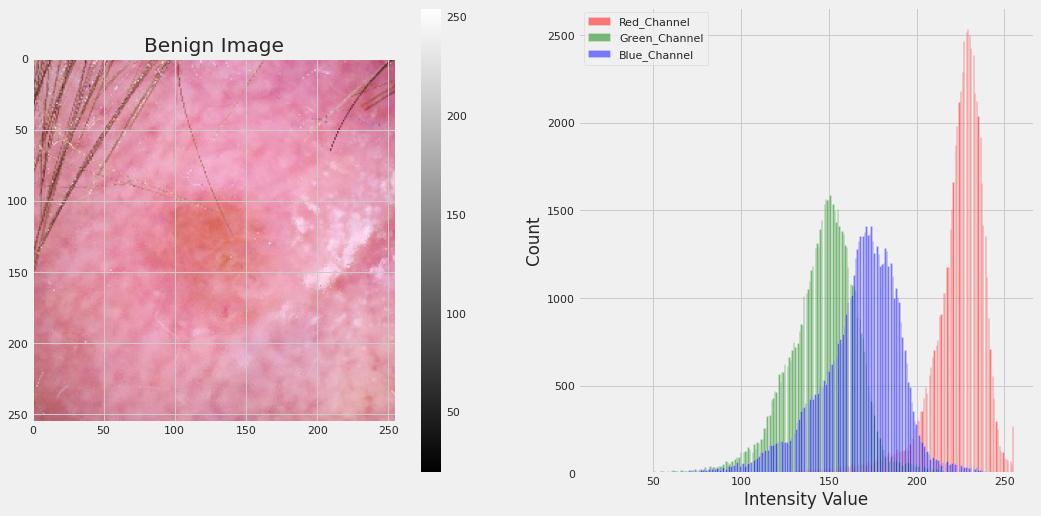

In [29]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['image_name'][0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

### Malignant category

Image dimensions:  (256, 256)
Maximum pixel value : 255.0 ; Minimum pixel value:20.0
Mean value of the pixels : 169.4 ; Standard deviation : 42.4


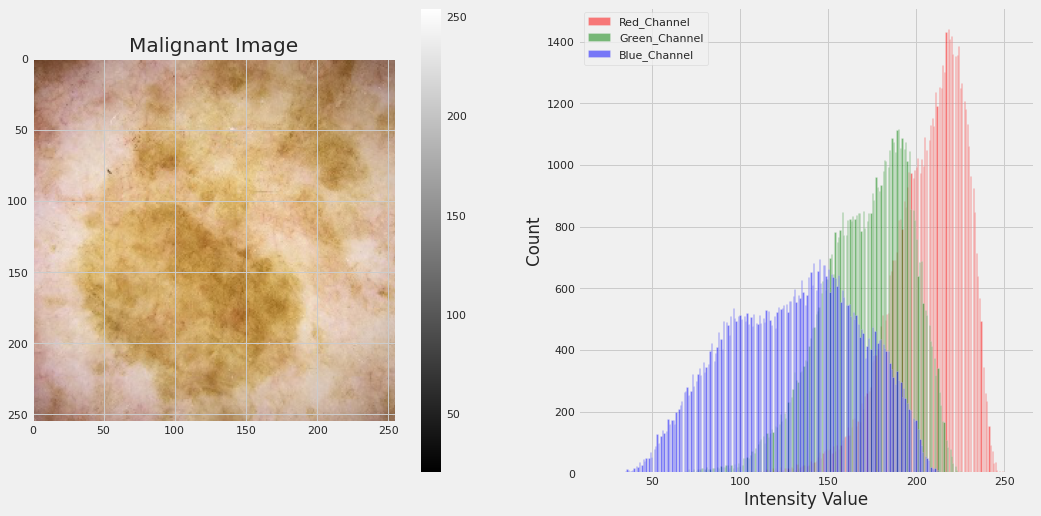

In [30]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['image_name'][235]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()